In [2]:
!pip install opencv-python-headless
!pip install torch torchvision torchaudio
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\IBM INTERNSHIP\yolov5


fatal: destination path 'yolov5' already exists and is not an empty directory.


In [3]:
import torch

# Use absolute path OR '.' if you're inside the yolov5 directory already
model = torch.hub.load('.', 'yolov5s', source='local')  # Fixed path
model.conf = 0.3  # Optional: confidence threshold

YOLOv5  2025-6-15 Python-3.11.1 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2060 with Max-Q Design, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


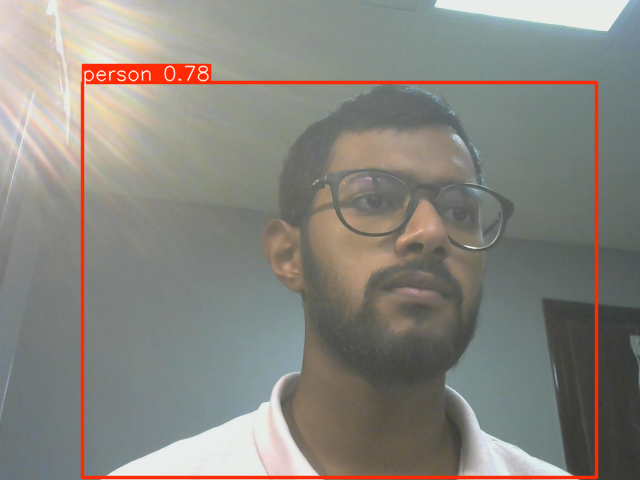

In [6]:
import warnings
warnings.filterwarnings('ignore')


import cv2
from IPython.display import display, clear_output
from PIL import Image

# Open webcam (0 = default camera)
cap = cv2.VideoCapture(0)

frame_count = 0  # Limit frame count for testing in Jupyter

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    # Run detection
    results = model(frame)

    # Draw results
    annotated_frame = results.render()[0]  # returns list of frames with boxes

    # Convert to RGB and show in Jupyter
    rgb_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(rgb_frame)
    clear_output(wait=True)
    display(img)

    # Stop after 150 frames
    frame_count += 1
    if frame_count >= 150:
        break

# Release webcam
cap.release()


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

# Set paths
data_dir = r"C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\IBM INTERNSHIP\archive"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Data transforms
transform = transforms.Compose([
    transforms.Grayscale(),  # FER images are grayscale
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Class names
classes = train_dataset.classes
print("Classes:", classes)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input: 1x48x48
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),  # 32x24x24

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # 64x12x12

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # 128x6x6
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [6]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: NVIDIA GeForce RTX 2060 with Max-Q Design


# TRAINING

In [7]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN(num_classes=len(classes)).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
epochs = 10

In [8]:
from torch.utils.data import random_split

val_size = int(0.1 * len(train_dataset))  # 10% for validation
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)

In [12]:
from tqdm import tqdm

best_val_loss = float('inf')
patience = 3
patience_counter = 0
epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item())

    train_accuracy = 100 * train_correct / train_total
    avg_train_loss = train_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    print(f"Epoch {epoch+1} Summary: "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # --- Early Stopping Check ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_emotion_model.pth")
        print("✅ Model saved (new best validation loss)")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Early stopping counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break


Epoch 1/20: 100%|████████████████████████████████████████████████████████████████████| 404/404 [03:54<00:00,  1.72it/s, loss=1.31]


Epoch 1 Summary: Train Loss: 1.6623, Train Acc: 34.42%, Val Loss: 1.4400, Val Acc: 45.23%
✅ Model saved (new best validation loss)


Epoch 2/20: 100%|████████████████████████████████████████████████████████████████████| 404/404 [00:20<00:00, 19.43it/s, loss=1.62]


Epoch 2 Summary: Train Loss: 1.4064, Train Acc: 45.73%, Val Loss: 1.2818, Val Acc: 51.05%
✅ Model saved (new best validation loss)


Epoch 3/20: 100%|████████████████████████████████████████████████████████████████████| 404/404 [00:21<00:00, 18.47it/s, loss=1.33]


Epoch 3 Summary: Train Loss: 1.2798, Train Acc: 50.60%, Val Loss: 1.2037, Val Acc: 54.29%
✅ Model saved (new best validation loss)


Epoch 4/20: 100%|████████████████████████████████████████████████████████████████████| 404/404 [00:21<00:00, 18.59it/s, loss=1.21]


Epoch 4 Summary: Train Loss: 1.1740, Train Acc: 55.06%, Val Loss: 1.1636, Val Acc: 56.27%
✅ Model saved (new best validation loss)


Epoch 5/20: 100%|████████████████████████████████████████████████████████████████████| 404/404 [00:21<00:00, 18.36it/s, loss=1.07]


Epoch 5 Summary: Train Loss: 1.0764, Train Acc: 58.93%, Val Loss: 1.1655, Val Acc: 57.49%
⚠️ No improvement. Early stopping counter: 1/3


Epoch 6/20: 100%|█████████████████████████████████████████████████████████████████████| 404/404 [00:22<00:00, 17.89it/s, loss=1.4]


Epoch 6 Summary: Train Loss: 0.9947, Train Acc: 62.48%, Val Loss: 1.1543, Val Acc: 57.87%
✅ Model saved (new best validation loss)


Epoch 7/20: 100%|████████████████████████████████████████████████████████████████████| 404/404 [00:22<00:00, 17.81it/s, loss=1.02]


Epoch 7 Summary: Train Loss: 0.8824, Train Acc: 66.16%, Val Loss: 1.1513, Val Acc: 57.91%
✅ Model saved (new best validation loss)


Epoch 8/20: 100%|███████████████████████████████████████████████████████████████████| 404/404 [00:23<00:00, 17.50it/s, loss=0.728]


Epoch 8 Summary: Train Loss: 0.7929, Train Acc: 70.02%, Val Loss: 1.2187, Val Acc: 57.42%
⚠️ No improvement. Early stopping counter: 1/3


Epoch 9/20: 100%|████████████████████████████████████████████████████████████████████| 404/404 [00:23<00:00, 17.43it/s, loss=0.75]


Epoch 9 Summary: Train Loss: 0.6972, Train Acc: 73.43%, Val Loss: 1.2166, Val Acc: 58.92%
⚠️ No improvement. Early stopping counter: 2/3


Epoch 10/20: 100%|██████████████████████████████████████████████████████████████████| 404/404 [00:23<00:00, 17.23it/s, loss=0.632]


Epoch 10 Summary: Train Loss: 0.6193, Train Acc: 76.37%, Val Loss: 1.2724, Val Acc: 59.16%
⚠️ No improvement. Early stopping counter: 3/3
⛔ Early stopping triggered.


In [8]:
model.load_state_dict(torch.load("best_emotion_model.pth"))
model.eval()

EmotionCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropo

In [14]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 57.50%


# GoogleNet

In [9]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels by duplicating
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])



In [10]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import os

# Paths
data_dir = r"C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\IBM INTERNSHIP\archive"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Datasets and loaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Class info
classes = train_dataset.classes
num_classes = len(classes)
print("Classes:", classes)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load GoogLeNet with aux_logits
model = models.googlenet(pretrained=True, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)

# Training config
num_epochs = 30
patience = 5
best_val_loss = float('inf')
early_stop_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs_tuple = model(images)
        outputs, aux2, aux1 = outputs_tuple  # GoogLeNet returns (main, aux2, aux1)

        loss_main = criterion(outputs, labels)
        loss_aux1 = criterion(aux1, labels)
        loss_aux2 = criterion(aux2, labels)

        loss = loss_main + 0.3 * loss_aux1 + 0.3 * loss_aux2
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Only main output in eval mode
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_acc = 100. * val_correct / val_total
    print(f"\nValidation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_googlenet_emotion_model.pth")
        print("✅ Saved new best model.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Using device: cuda


Epoch 1/30: 100%|███████████████████████████████████████████████| 449/449 [18:02<00:00,  2.41s/it, acc=53.9, loss=1.72]



Validation Loss: 1.1194 | Validation Accuracy: 56.52%
✅ Saved new best model.


Epoch 2/30: 100%|███████████████████████████████████████████████| 449/449 [12:10<00:00,  1.63s/it, acc=60.6, loss=1.59]



Validation Loss: 1.0489 | Validation Accuracy: 60.59%
✅ Saved new best model.


Epoch 3/30: 100%|█████████████████████████████████████████████████| 449/449 [13:45<00:00,  1.84s/it, acc=63, loss=1.88]



Validation Loss: 1.0677 | Validation Accuracy: 59.39%


Epoch 4/30: 100%|███████████████████████████████████████████████| 449/449 [13:23<00:00,  1.79s/it, acc=64.7, loss=1.66]



Validation Loss: 1.0600 | Validation Accuracy: 61.28%


Epoch 5/30: 100%|█████████████████████████████████████████████████| 449/449 [13:52<00:00,  1.86s/it, acc=66, loss=1.44]



Validation Loss: 0.9445 | Validation Accuracy: 64.54%
✅ Saved new best model.


Epoch 6/30: 100%|██████████████████████████████████████████████████| 449/449 [12:25<00:00,  1.66s/it, acc=67.6, loss=1]



Validation Loss: 0.9403 | Validation Accuracy: 65.03%
✅ Saved new best model.


Epoch 7/30: 100%|███████████████████████████████████████████████| 449/449 [13:32<00:00,  1.81s/it, acc=68.7, loss=1.76]



Validation Loss: 0.9354 | Validation Accuracy: 65.44%
✅ Saved new best model.


Epoch 8/30: 100%|█████████████████████████████████████████████████| 449/449 [13:16<00:00,  1.77s/it, acc=70, loss=1.62]



Validation Loss: 0.9383 | Validation Accuracy: 64.93%


Epoch 9/30: 100%|███████████████████████████████████████████████| 449/449 [14:40<00:00,  1.96s/it, acc=71.1, loss=1.92]



Validation Loss: 0.9378 | Validation Accuracy: 65.38%


Epoch 10/30: 100%|██████████████████████████████████████████████| 449/449 [21:44<00:00,  2.90s/it, acc=72.2, loss=1.51]



Validation Loss: 0.9832 | Validation Accuracy: 64.74%


Epoch 11/30: 100%|██████████████████████████████████████████████| 449/449 [20:02<00:00,  2.68s/it, acc=73.4, loss=1.56]



Validation Loss: 0.9177 | Validation Accuracy: 65.90%
✅ Saved new best model.


Epoch 12/30: 100%|██████████████████████████████████████████████| 449/449 [14:37<00:00,  1.95s/it, acc=74.8, loss=1.41]



Validation Loss: 0.9383 | Validation Accuracy: 66.97%


Epoch 13/30: 100%|██████████████████████████████████████████████| 449/449 [12:56<00:00,  1.73s/it, acc=75.9, loss=1.38]



Validation Loss: 0.9735 | Validation Accuracy: 66.05%


Epoch 14/30: 100%|█████████████████████████████████████████████| 449/449 [14:42<00:00,  1.97s/it, acc=76.8, loss=0.954]



Validation Loss: 0.9197 | Validation Accuracy: 68.11%


Epoch 15/30: 100%|██████████████████████████████████████████████| 449/449 [13:00<00:00,  1.74s/it, acc=78.3, loss=1.16]



Validation Loss: 0.9481 | Validation Accuracy: 67.48%


Epoch 16/30: 100%|███████████████████████████████████████████████| 449/449 [14:44<00:00,  1.97s/it, acc=84.7, loss=0.8]



Validation Loss: 0.9764 | Validation Accuracy: 69.67%
⏹️ Early stopping triggered.


In [12]:
# Recreate the model with aux_logits=True to match training
model = models.googlenet(pretrained=False, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)
model = model.to(device)

# Load the trained weights
model.load_state_dict(torch.load("best_googlenet_emotion_model.pth"))
model.eval()


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [14]:
correct = 0
total = 0
test_loss = 0.0
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Per-class accuracy
        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

avg_test_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total

print(f"\n📊 Test Loss: {avg_test_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

# Per-class accuracy breakdown
print("\n🔍 Per-Class Accuracy:")
for i, class_name in enumerate(classes):
    if class_total[i] == 0:
        print(f"{class_name}: No samples")
    else:
        acc = 100 * class_correct[i] / class_total[i]
        print(f"{class_name}: {acc:.2f}%")



📊 Test Loss: 1.3717 | Test Accuracy: 50.72%

🔍 Per-Class Accuracy:
angry: 40.61%
disgust: 9.01%
fear: 48.93%
happy: 81.85%
neutral: 32.93%
sad: 39.62%
surprise: 46.81%


# GoogleNet Run 2

In [9]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [10]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import os

# Paths
data_dir = r"C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\IBM INTERNSHIP\archive"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Datasets and loaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Class info
classes = train_dataset.classes
num_classes = len(classes)
print("Classes:", classes)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load GoogLeNet with aux_logits
model = models.googlenet(pretrained=True, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)
model = model.to(device)

# Loss, optimizer, scheduler
from collections import Counter

targets = [label for _, label in train_dataset]
class_counts = Counter(targets)
total = sum(class_counts.values())
class_weights = [total / class_counts[i] for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=class_weights)
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)

# Training config
num_epochs = 50
patience = 10
best_val_loss = float('inf')
early_stop_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs_tuple = model(images)
        outputs, aux2, aux1 = outputs_tuple  # GoogLeNet returns (main, aux2, aux1)

        loss_main = criterion(outputs, labels)
        loss_aux1 = criterion(aux1, labels)
        loss_aux2 = criterion(aux2, labels)

        loss = loss_main + 0.3 * loss_aux1 + 0.3 * loss_aux2
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Only main output in eval mode
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_acc = 100. * val_correct / val_total
    print(f"\nValidation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_googlenet_emotion_model.pth")
        print("✅ Saved new best model.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Using device: cuda


Epoch 1/50: 100%|██████████████████████████████████████████████████████████| 449/449 [04:53<00:00,  1.53it/s, acc=44.1, loss=3.08]



Validation Loss: 1.7457 | Validation Accuracy: 55.03%
✅ Saved new best model.


Epoch 2/50: 100%|██████████████████████████████████████████████████████████| 449/449 [12:03<00:00,  1.61s/it, acc=54.1, loss=2.24]



Validation Loss: 1.7530 | Validation Accuracy: 52.90%


Epoch 3/50: 100%|██████████████████████████████████████████████████████████| 449/449 [11:55<00:00,  1.59s/it, acc=57.7, loss=2.35]



Validation Loss: 1.7118 | Validation Accuracy: 56.76%
✅ Saved new best model.


Epoch 4/50: 100%|██████████████████████████████████████████████████████████| 449/449 [11:37<00:00,  1.55s/it, acc=60.6, loss=1.63]



Validation Loss: 1.6295 | Validation Accuracy: 61.28%
✅ Saved new best model.


Epoch 5/50: 100%|██████████████████████████████████████████████████████████| 449/449 [11:04<00:00,  1.48s/it, acc=62.2, loss=1.82]



Validation Loss: 1.5925 | Validation Accuracy: 63.21%
✅ Saved new best model.


Epoch 6/50: 100%|████████████████████████████████████████████████████████████| 449/449 [13:08<00:00,  1.76s/it, acc=64, loss=2.08]



Validation Loss: 1.6294 | Validation Accuracy: 61.77%


Epoch 7/50: 100%|██████████████████████████████████████████████████████████| 449/449 [12:10<00:00,  1.63s/it, acc=65.6, loss=2.51]



Validation Loss: 1.5911 | Validation Accuracy: 64.06%
✅ Saved new best model.


Epoch 8/50: 100%|█████████████████████████████████████████████████████████████| 449/449 [12:16<00:00,  1.64s/it, acc=67, loss=2.7]



Validation Loss: 1.5638 | Validation Accuracy: 65.53%
✅ Saved new best model.


Epoch 9/50: 100%|██████████████████████████████████████████████████████████| 449/449 [11:59<00:00,  1.60s/it, acc=68.8, loss=2.31]



Validation Loss: 1.6283 | Validation Accuracy: 63.01%


Epoch 10/50: 100%|█████████████████████████████████████████████████████████| 449/449 [11:51<00:00,  1.59s/it, acc=69.6, loss=3.01]



Validation Loss: 1.5991 | Validation Accuracy: 64.63%


Epoch 11/50: 100%|█████████████████████████████████████████████████████████| 449/449 [12:13<00:00,  1.63s/it, acc=71.3, loss=2.45]



Validation Loss: 1.5637 | Validation Accuracy: 66.31%
✅ Saved new best model.


Epoch 12/50: 100%|██████████████████████████████████████████████████████████| 449/449 [12:24<00:00,  1.66s/it, acc=72.8, loss=2.2]



Validation Loss: 1.5837 | Validation Accuracy: 65.28%


Epoch 13/50: 100%|█████████████████████████████████████████████████████████| 449/449 [12:04<00:00,  1.61s/it, acc=78.4, loss=2.24]



Validation Loss: 1.5152 | Validation Accuracy: 69.34%
✅ Saved new best model.


Epoch 14/50: 100%|█████████████████████████████████████████████████████████| 449/449 [12:21<00:00,  1.65s/it, acc=80.6, loss=1.66]



Validation Loss: 1.5273 | Validation Accuracy: 69.10%


Epoch 15/50: 100%|█████████████████████████████████████████████████████████| 449/449 [12:09<00:00,  1.63s/it, acc=82.1, loss=2.38]



Validation Loss: 1.5275 | Validation Accuracy: 69.96%


Epoch 16/50: 100%|█████████████████████████████████████████████████████████| 449/449 [12:04<00:00,  1.61s/it, acc=83.9, loss=1.91]



Validation Loss: 1.5340 | Validation Accuracy: 70.09%


Epoch 17/50: 100%|█████████████████████████████████████████████████████████| 449/449 [12:21<00:00,  1.65s/it, acc=85.1, loss=1.97]



Validation Loss: 1.5556 | Validation Accuracy: 69.75%


Epoch 18/50: 100%|█████████████████████████████████████████████████████████| 449/449 [12:22<00:00,  1.65s/it, acc=87.9, loss=1.85]



Validation Loss: 1.5601 | Validation Accuracy: 70.14%


Epoch 19/50: 100%|█████████████████████████████████████████████████████████| 449/449 [11:54<00:00,  1.59s/it, acc=88.7, loss=1.51]



Validation Loss: 1.5696 | Validation Accuracy: 70.08%


Epoch 20/50: 100%|█████████████████████████████████████████████████████████| 449/449 [11:39<00:00,  1.56s/it, acc=88.9, loss=1.91]



Validation Loss: 1.5735 | Validation Accuracy: 69.94%


Epoch 21/50: 100%|█████████████████████████████████████████████████████████| 449/449 [11:51<00:00,  1.58s/it, acc=89.5, loss=2.18]



Validation Loss: 1.5850 | Validation Accuracy: 69.67%


Epoch 22/50: 100%|█████████████████████████████████████████████████████████| 449/449 [12:24<00:00,  1.66s/it, acc=89.9, loss=2.03]



Validation Loss: 1.5856 | Validation Accuracy: 70.13%


Epoch 23/50: 100%|████████████████████████████████████████████████████████████| 449/449 [12:14<00:00,  1.63s/it, acc=90, loss=2.1]



Validation Loss: 1.5920 | Validation Accuracy: 69.92%
⏹️ Early stopping triggered.


In [13]:
from torchvision import models
import torch.nn as nn

model = models.googlenet(aux_logits=True)  # ← safer than specifying pretrained=True/False here
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

model.load_state_dict(torch.load("best_googlenet_emotion_model.pth"))
model.eval()
model.to(device)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [14]:
correct = 0
total = 0
test_loss = 0.0
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Per-class accuracy
        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

avg_test_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total

print(f"\n📊 Test Loss: {avg_test_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

# Per-class accuracy breakdown
print("\n🔍 Per-Class Accuracy:")
for i, class_name in enumerate(classes):
    if class_total[i] == 0:
        print(f"{class_name}: No samples")
    else:
        acc = 100 * class_correct[i] / class_total[i]
        print(f"{class_name}: {acc:.2f}%")



📊 Test Loss: 1.8154 | Test Accuracy: 54.61%

🔍 Per-Class Accuracy:
angry: 38.10%
disgust: 33.33%
fear: 31.64%
happy: 73.22%
neutral: 57.50%
sad: 55.33%
surprise: 59.69%


# Run 3

In [20]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [15]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import os
from collections import Counter

# ---  Focal Loss Implementation ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Tensor of shape [num_classes]
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)  # prevents nans when probability is 0
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            at = self.alpha.gather(0, targets)
            focal_loss = at * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Paths
data_dir = r"C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\IBM INTERNSHIP\archive"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")



# Datasets and loaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Class info
classes = train_dataset.classes
num_classes = len(classes)
print("Classes:", classes)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load GoogLeNet with aux_logits
model = models.googlenet(pretrained=True, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)
model = model.to(device)

# Class weights
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)
total = sum(class_counts.values())
class_weights = [total / class_counts[i] for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Criterion: Focal Loss with class weights
criterion = FocalLoss(alpha=class_weights, gamma=2.0)

# Optimizer and scheduler
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)

# Training config
num_epochs = 50
patience = 10
best_val_loss = float('inf')
early_stop_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs_tuple = model(images)
        outputs, aux2, aux1 = outputs_tuple  # GoogLeNet returns (main, aux2, aux1)

        loss_main = criterion(outputs, labels)
        loss_aux1 = criterion(aux1, labels)
        loss_aux2 = criterion(aux2, labels)

        loss = loss_main + 0.3 * loss_aux1 + 0.3 * loss_aux2
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Only main output in eval mode
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_acc = 100. * val_correct / val_total
    print(f"\nValidation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_googlenet_emotion_model.pth")
        print("✅ Saved new best model.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Using device: cuda


Epoch 1/50: 100%|██████████████████████████████████████████████████████████| 449/449 [06:25<00:00,  1.16it/s, acc=45.5, loss=8.19]



Validation Loss: 5.6000 | Validation Accuracy: 52.83%
✅ Saved new best model.


Epoch 2/50: 100%|██████████████████████████████████████████████████████████| 449/449 [14:47<00:00,  1.98s/it, acc=52.8, loss=7.77]



Validation Loss: 5.6765 | Validation Accuracy: 52.49%


Epoch 3/50: 100%|██████████████████████████████████████████████████████████| 449/449 [14:34<00:00,  1.95s/it, acc=55.1, loss=8.23]



Validation Loss: 4.6498 | Validation Accuracy: 56.13%
✅ Saved new best model.


Epoch 4/50: 100%|██████████████████████████████████████████████████████████| 449/449 [14:36<00:00,  1.95s/it, acc=58.2, loss=8.27]



Validation Loss: 4.6373 | Validation Accuracy: 58.69%
✅ Saved new best model.


Epoch 5/50: 100%|████████████████████████████████████████████████████████████| 449/449 [15:25<00:00,  2.06s/it, acc=59, loss=8.26]



Validation Loss: 4.4526 | Validation Accuracy: 59.06%
✅ Saved new best model.


Epoch 6/50: 100%|██████████████████████████████████████████████████████████| 449/449 [15:39<00:00,  2.09s/it, acc=60.3, loss=4.74]



Validation Loss: 4.8316 | Validation Accuracy: 53.97%


Epoch 7/50: 100%|███████████████████████████████████████████████████████████| 449/449 [15:35<00:00,  2.08s/it, acc=61.6, loss=6.2]



Validation Loss: 4.5182 | Validation Accuracy: 61.28%


Epoch 8/50: 100%|██████████████████████████████████████████████████████████| 449/449 [12:36<00:00,  1.68s/it, acc=62.8, loss=7.51]



Validation Loss: 4.1349 | Validation Accuracy: 60.60%
✅ Saved new best model.


Epoch 9/50: 100%|██████████████████████████████████████████████████████████| 449/449 [13:55<00:00,  1.86s/it, acc=63.7, loss=5.16]



Validation Loss: 4.1368 | Validation Accuracy: 60.25%


Epoch 10/50: 100%|██████████████████████████████████████████████████████████| 449/449 [15:31<00:00,  2.07s/it, acc=64.5, loss=5.3]



Validation Loss: 4.0010 | Validation Accuracy: 62.96%
✅ Saved new best model.


Epoch 11/50: 100%|█████████████████████████████████████████████████████████| 449/449 [15:21<00:00,  2.05s/it, acc=65.3, loss=4.76]



Validation Loss: 3.9408 | Validation Accuracy: 63.76%
✅ Saved new best model.


Epoch 12/50: 100%|█████████████████████████████████████████████████████████| 449/449 [15:09<00:00,  2.03s/it, acc=65.6, loss=5.06]



Validation Loss: 3.9711 | Validation Accuracy: 63.67%


Epoch 13/50: 100%|█████████████████████████████████████████████████████████| 449/449 [13:45<00:00,  1.84s/it, acc=66.4, loss=5.74]



Validation Loss: 4.0185 | Validation Accuracy: 62.12%


Epoch 14/50: 100%|██████████████████████████████████████████████████████████| 449/449 [12:37<00:00,  1.69s/it, acc=68.2, loss=4.9]



Validation Loss: 3.9410 | Validation Accuracy: 65.21%


Epoch 15/50: 100%|██████████████████████████████████████████████████████████| 449/449 [12:47<00:00,  1.71s/it, acc=68.1, loss=5.7]



Validation Loss: 4.2737 | Validation Accuracy: 65.88%


Epoch 16/50: 100%|█████████████████████████████████████████████████████████| 449/449 [27:53<00:00,  3.73s/it, acc=73.3, loss=4.18]



Validation Loss: 3.8039 | Validation Accuracy: 67.89%
✅ Saved new best model.


Epoch 17/50: 100%|█████████████████████████████████████████████████████████| 449/449 [14:28<00:00,  1.93s/it, acc=74.9, loss=4.06]



Validation Loss: 3.9511 | Validation Accuracy: 67.92%


Epoch 18/50: 100%|███████████████████████████████████████████████████████████| 449/449 [14:48<00:00,  1.98s/it, acc=76, loss=3.42]



Validation Loss: 4.1147 | Validation Accuracy: 68.08%


Epoch 19/50: 100%|█████████████████████████████████████████████████████████| 449/449 [14:47<00:00,  1.98s/it, acc=77.2, loss=4.07]



Validation Loss: 4.3478 | Validation Accuracy: 68.17%


Epoch 20/50: 100%|██████████████████████████████████████████████████████████| 449/449 [14:44<00:00,  1.97s/it, acc=78.2, loss=2.9]



Validation Loss: 4.3147 | Validation Accuracy: 67.99%


Epoch 21/50: 100%|█████████████████████████████████████████████████████████| 449/449 [14:32<00:00,  1.94s/it, acc=80.5, loss=2.39]



Validation Loss: 4.5489 | Validation Accuracy: 68.81%


Epoch 22/50: 100%|█████████████████████████████████████████████████████████| 449/449 [13:27<00:00,  1.80s/it, acc=80.8, loss=1.73]



Validation Loss: 4.6759 | Validation Accuracy: 68.51%


Epoch 23/50: 100%|█████████████████████████████████████████████████████████| 449/449 [13:53<00:00,  1.86s/it, acc=81.5, loss=4.58]



Validation Loss: 4.8718 | Validation Accuracy: 68.61%


Epoch 24/50: 100%|█████████████████████████████████████████████████████████| 449/449 [14:51<00:00,  1.99s/it, acc=81.6, loss=3.25]



Validation Loss: 4.8691 | Validation Accuracy: 68.82%


Epoch 25/50: 100%|████████████████████████████████████████████████████████| 449/449 [15:46<00:00,  2.11s/it, acc=82.5, loss=0.755]



Validation Loss: 4.8610 | Validation Accuracy: 68.97%


Epoch 26/50: 100%|█████████████████████████████████████████████████████████| 449/449 [15:28<00:00,  2.07s/it, acc=82.2, loss=3.47]



Validation Loss: 4.9388 | Validation Accuracy: 68.82%
⏹️ Early stopping triggered.


In [21]:
from torchvision import models
import torch.nn as nn

# Recreate the model architecture
model = models.googlenet(pretrained=True, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

# Load the saved weights
model.load_state_dict(torch.load("best_googlenet_emotion_model.pth", map_location=device))

# Set to evaluation mode
model.eval()
model.to(device)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [17]:
correct = 0
total = 0
test_loss = 0.0
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Per-class accuracy
        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

avg_test_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total

print(f"\n📊 Test Loss: {avg_test_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

# Per-class accuracy breakdown
print("\n🔍 Per-Class Accuracy:")
for i, class_name in enumerate(classes):
    if class_total[i] == 0:
        print(f"{class_name}: No samples")
    else:
        acc = 100 * class_correct[i] / class_total[i]
        print(f"{class_name}: {acc:.2f}%")



📊 Test Loss: 3.8039 | Test Accuracy: 67.89%

🔍 Per-Class Accuracy:
angry: 66.28%
disgust: 74.77%
fear: 41.99%
happy: 85.63%
neutral: 69.10%
sad: 51.72%
surprise: 85.32%


In [20]:
#POPUP TESTER
'''
import cv2

def main():
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow("Test Webcam Popup", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

main()
'''

In [ ]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [ ]:
from torchvision import models
import torch.nn as nn

# Recreate the model architecture
model = models.googlenet(pretrained=True, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

# Load the saved weights
model.load_state_dict(torch.load("best_googlenet_emotion_model.pth", map_location=device))

# Set to evaluation mode
model.eval()
model.to(device)


In [22]:
import cv2
import torch
import numpy as np
from PIL import Image
from collections import deque, Counter
from torchvision import transforms
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# --- Setup ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load YOLOv5 person detection model
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
yolo_model.conf = 0.5
yolo_model.to(device)

# Load your GoogLeNet emotion model and classes
model.load_state_dict(torch.load("best_googlenet_emotion_model.pth", map_location=device))
model.eval()
model.to(device)
emotion_model = model
emotion_model.eval()

emotion_labels = classes  # your list of emotion strings, e.g. ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Image transform for emotion model input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Buffer for smoothing predictions
prediction_buffer = deque(maxlen=30)

# --- Webcam Capture ---
cap = cv2.VideoCapture(0)
print("🟢 Starting real-time emotion detection...")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    # YOLOv5 detection (detect persons)
    results = yolo_model(frame)
    detections = results.xyxy[0].cpu().numpy()  # convert to numpy for easier use

    annotated = frame.copy()

    for *box, conf, cls in detections:
        if int(cls) == 0:  # class 0 = person
            x1, y1, x2, y2 = map(int, box)

            # Crop face region from detected person bounding box
            face = frame[y1:y2, x1:x2]
            try:
                face_pil = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
                face_tensor = transform(face_pil).unsqueeze(0).to(device)

                with torch.no_grad():
                    output = emotion_model(face_tensor)
                    if isinstance(output, tuple):
                        output = output[0]
                    pred = torch.argmax(output, dim=1).item()
                    pred_label = emotion_labels[pred]

                # Append prediction to buffer for smoothing
                prediction_buffer.append(pred_label)

                # Get most common prediction in buffer
                smoothed_prediction = Counter(prediction_buffer).most_common(1)[0][0]

                # Draw bounding box + label on annotated frame
                cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(annotated, smoothed_prediction.upper(), (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

            except Exception as e:
                print("Skipping face:", e)
            break  # remove this break if you want to detect all persons per frame

    # Show annotated frame in popup window
    cv2.imshow("Real-Time Emotion Detection", annotated)

    # Exit loop on 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()
print("🛑 Stopped.")


Using cache found in C:\Users\Prani/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-6-15 Python-3.11.1 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2060 with Max-Q Design, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


🟢 Starting real-time emotion detection...
🛑 Stopped.
